#### Steven Raaijmakers (10804242) & Marcus van Bergen (10871993)

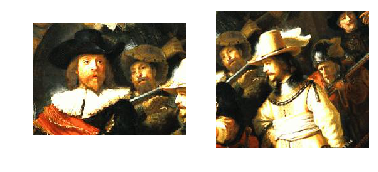

In [1]:
import matplotlib.pyplot as plt
import cv2
from __future__ import division, print_function
import numpy as np
from skimage.transform import warp
from pylab import *
import cv2
import random
#from ginput import ginput



f1 = plt.imread('./images/nachtwacht1.jpg')/255
plt.subplot(121); plt.imshow(f1); plt.axis('off');
f2 = plt.imread('./images/nachtwacht2.jpg')/255
plt.subplot(122); plt.imshow(f2); plt.axis('off');
plt.show()

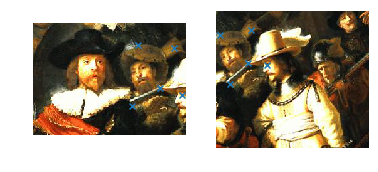

In [2]:
#Added one more point to show the array can handle n points
xy = np.array([[ 157, 32],
                [ 211, 37],
                [ 222,107],
                [ 147,124],
                [190, 97]]) 

# points in right image:
xaya = np.array([[  6, 38],
                  [ 56, 31],
                  [ 82, 87],
                  [ 22,118],
                  [51, 83]])

plt.subplot(121); plt.imshow(f1); plt.axis('off');

plt.scatter(xy[:,0], xy[:,1], marker='x');

plt.subplot(122); plt.imshow(f2); plt.axis('off');

plt.scatter(xaya[:,0], xaya[:,1], marker='x');

plt.show()

## Homogenius array $M$

This for-loop defines the homogenius array $M$ which we use for Perspective Transformations but only for $n$ input. 
This way we can take as many points as we want and we can calculate the matrix. From here the projection folows using th SVD trick and then doing an image warp.
 

[[   157     32      1      0      0      0   -942   -192     -6]
 [     0      0      0    157     32      1  -5966  -1216    -38]
 [   211     37      1      0      0      0 -11816  -2072    -56]
 [     0      0      0    211     37      1  -6541  -1147    -31]
 [   222    107      1      0      0      0 -18204  -8774    -82]
 [     0      0      0    222    107      1 -19314  -9309    -87]
 [   147    124      1      0      0      0  -3234  -2728    -22]
 [     0      0      0    147    124      1 -17346 -14632   -118]
 [   190     97      1      0      0      0  -9690  -4947    -51]
 [     0      0      0    190     97      1 -15770  -8051    -83]]


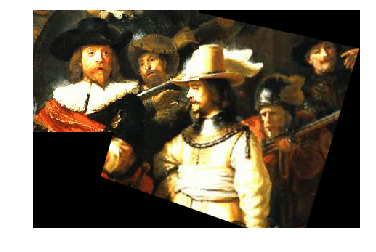

In [3]:
def trans(xy, xaya):
    
    # Get the number of points we want
    size = xy.shape
    size = size[0]
    
    # Initialize the homogenius array
    M = np.zeros([0, 9])
    
    # Fill it row per row with the matrix format and append it to the X axis
    for x in range(0, size):
        M = np.append(M, [[xy[x][0], xy[x][1], 1, 0, 0, 0, -xaya[x][0] * xy[x][0], -xaya[x][0] * xy[x][1], -xaya[x][0]]], 
                       axis=0)
        M = np.append(M, [[0, 0, 0, xy[x][0], xy[x][1], 1, -xaya[x][1] * xy[x][0], -xaya[x][1] * xy[x][1], -xaya[x][1]]], 
                       axis=0)
        
    M = M.astype(int)
   
    print (np.array(M))
    
    # decomposition to get V^t
    _, _, V = np.linalg.svd(M)

    # Last colomn of V will be reshaped to a 3x3 which will be used
    # for the warp
    p = V[-1]
    p = (np.reshape(p, (3,3)))
    
    return p

P = trans(xy, xaya)

f_stitched = warp(f2, P, output_shape=(300,450))

M, N = f1.shape[:2]

f_stitched[0:M, 0:N, :] = f1

plt.imshow(f_stitched); plt.axis('off')

plt.show()

# SIFT

Here we take a look at SIFT and how it works. From the following code below we import the nachwacht image and run SIFT on it. SIFT, better known as Scale Invariant Feature Transform. SIFT is a way to find image descriptors, pieces within an image which we can use to find overlaping pieces in another image. Of course this can be done in another way, for instance simple corner detectors, but the SIFT algorithm does many other things making it resilliant to scaling, rotation, illumination, and viewpoint changes. 

## "Under the hood" explanation of SIFT:

## Step 1: Scale space
 The first step to the SIFT algorithm is to generate a scale space. What this means, is that in SIFT we take the given image and resized it $n$ times, usually 4-5 times leads to good results. Each resized image gets a Gaussian blur on it on which every $n$ image gets more and more blurry.

The purpose for this is to be able to build a base for the different ways the details in the image can be represented. We generate different scale and blurs of our original image to better find the details late in the SIFT algorithm.

## Step 2: LoG Approximation
The purpose of this step is to calculate the Difference of Gaussians, better known as DoG. Orignally we would do the Laplacian of Gaussian (LOG) which is a method to find the DoG. 

Let's take a step back... DoG, is an image which is generated from two other images. In a DoG we can find interesting keypoints for an image which we will later use. To generate the DoG we orignally use LOG, which is a computationally heavy operation. 

### The original LOG method goes as follows: 
Take an aimge, and blur it. Then you caclulate the laplacian on it which find corners and edges in the image itself. This is a way to find keypoints in the image.

Instead of doing this, we do an appoximation of the LoG, which is sort of like the LoG but then using pre-bluured images from Step 1. The purpose of this is to lower the computational time needed to generate the DoG.


## Step 3: Finding Keypoints
Now that we calculated the DoG of the image (Step 2) we can find the keypoints we want in an image. These will be used in laters steps.

The method of finding keypoints in an image is to calculate the local Maxima and Minima of the image, and the subpixel maima and minima (or in other implementations the interpolation). 

The way we find the maximum and minumum of a pixel is as follows:  We simpy itterate throught the entire image's pixels and check the value of it compared to it's neighbours. We also check this to the entire scale space of the images by check the pixels of the other DoG images, which gives us a very good result for the computed keypoints. The maximums or minimums calculated are then chosen as keypoints for the images.

To make the keypoints more accurate in location we can generate subpixel data for each keypoint with Taylor expansion:

![Alt text](./images/te.png)

What this expansion does is simply generate subpixel data which will tell us about the contrast of the highlighted pixel. This will be later used in Step 4.

## Step 4: Discarding low-contrast keypoints

What we do at this step is use the subpixel data generated from the taylor expansion above to remove/reject keypoints which don't really contribute to the image. Throughout the image we find keypoints indeed, however many times these keypoints have a low contrast to the other pixels. So using the data generated by the taylor expansion we can filter out said low contrast keypoints and only keeps the keypoints which are high contrast, which will be used later.

## Step 5: Orientation of keypoints
In this step each keypoint will be assigned an orientation based on it's local gradient. To find the orientation we simply look at the magintude of the gradient at different angles. These formulas are used to calculate the gradient magnitude and orientation:

![-](./images/gr.png)

This process is done for each keypoint and it's neighbouring pixels. We make an orientation histogram of 36 bins (360 degrees, 10 degrees per bin: see our histogram assignment for more information). The top 20% of the histogram's magnitude and orientation are assigned to the keypoint. In the case that there are more than one dominant regions for the orienataion a second keypoint is generated of the original keypoint but with the dominant orientation.

## Step 6: Keypoint descriptors
Now that we have our keypoints with descriptors we want to go further and calculate descriptors for these keypoints. Let's explain what this descriptor is:

First we start by taking a 16x16 window around the keypoint. Each of these windows is further broken down into a smller 4x4 window. In each of these sub-windows (One of the 4x4 windows) we can again calculate the gradient magnitudes and orientations using the method in step 5. These are then put into a 8 bin historgam and from there we can assign a magnitude and orientation vector, better known as the feature vector. We then normalize the feature vector to a unit length. We then subtract the keypoints orientation and the threshold value of each element of the feature vector to 0.2, and then we normalize once more. 


In [4]:
import cv2
print(cv2.__version__)

### Proof that I cannot get my CV version to update to anything higher like CV version 3.x

3.2.0


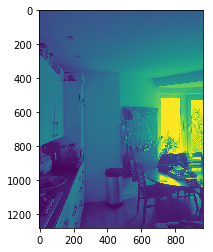

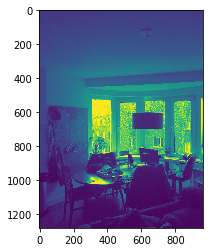

AttributeError: 'module' object has no attribute 'SIFT'

In [5]:
####### Sources  ###########
# http://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html
# http://www.aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/
# https://pythonprogramming.net/feature-matching-homography-python-opencv-tutorial/

import matplotlib.pyplot as plt
import cv2
from __future__ import division, print_function
import numpy as np
from skimage.transform import warp
from pylab import *
import cv2
import random



########   NOTE   ###########
# Source: https://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python
# The below code is used from SO, for the reason that I cannot get my CV2 img3 = cv2.drawMatches(...) function to work
# If this function did work the below code would not be needed. But I have used it from SO due to the complications
# and hardship endured trying to update my Conda openCV to version 2.4 or above. Above output showing my CV version.
######## END NOTE ###########
def drawMatches(img1, kp1, img2, kp2, matches):
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)
    return out

#Open the images 1 and 2
img1 = cv2.imread('./images/im1.jpg', 0)
img2 = cv2.imread('./images/im2.jpg', 0)

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

# Start the SIFT engine
sift = cv2.SIFT()

# Find keypoints in both the images
kp1, dscs1 = sift.detectAndCompute(img1, mask=None)
kp2, dscs2 = sift.detectAndCompute(img2, mask=None)

# Start CV2 matches
bf = cv2.BFMatcher()

# Run the matches for both the keypoints and sort them
matches = bf.match(dscs1,dscs2)
matches = sorted(matches, key = lambda x:x.distance)

# Build a temporary images which shows us the matches between the images
img3 = drawMatches(img1, kp1, img2, kp2, matches)
plt.imshow(img3)
plt.show()

####
# This is where the homographic array is found using RANSAC from OpenCV (tutoral, see Source for link).
###
sourcePoints = np.float32([kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
destinationPoints = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
# projection matrix P
P, mask = cv2.findHomography(sourcePoints, destinationPoints, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# Our source image will contain img2 which is warped using the P matrix above.
image_s = cv2.warpPerspective(img2, linalg.inv(P), (2000,2000))

#Get dimensions of the img1
height_img1,width_img1 = img1.shape[:2]

# We append img1 normally, because img2 is already ready in warped place.
# So now our panormama will be finished
for i in xrange(height_img1):
    for j in xrange(width_img1):
        image_s[i][j] = img1[i][j]

plt.imshow(image_s)
plt.show()

 

In [ ]:
####### Sources  ###########
# http://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html
# http://www.aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/
# https://pythonprogramming.net/feature-matching-homography-python-opencv-tutorial/

import matplotlib.pyplot as plt
import cv2
from __future__ import division, print_function
import numpy as np
from skimage.transform import warp
from pylab import *
import cv2
import random



########   NOTE   ###########
# Source: https://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python
# The below code is used from SO, for the reason that I cannot get my CV2 img3 = cv2.drawMatches(...) function to work
# If this function did work the below code would not be needed. But I have used it from SO due to the complications
# and hardship endured trying to update my Conda openCV to version 2.4 or above. Above output showing my CV version.
######## END NOTE ###########
def drawMatches(img1, kp1, img2, kp2, matches):
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)
    return out

#Open the images 1 and 2
img1 = cv2.imread('./images/nachtwacht1.jpg', 0)
img2 = cv2.imread('./images/nachtwacht2.jpg', 0)

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

# Start the SIFT engine
sift = cv2.SIFT()

# Find keypoints in both the images
kp1, dscs1 = sift.detectAndCompute(img1, mask=None)
kp2, dscs2 = sift.detectAndCompute(img2, mask=None)

# Start CV2 matches
bf = cv2.BFMatcher()

# Run the matches for both the keypoints and sort them
matches = bf.match(dscs1,dscs2)
matches = sorted(matches, key = lambda x:x.distance)

# Build a temporary images which shows us the matches between the images
img3 = drawMatches(img1, kp1, img2, kp2, matches)
plt.imshow(img3)
plt.show()

####
# This is where the homographic array is found using RANSAC from OpenCV (tutoral, see Source for link).
###
sourcePoints = np.float32([kp1[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
destinationPoints = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
# projection matrix P
P, mask = cv2.findHomography(sourcePoints, destinationPoints, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# Our source image will contain img2 which is warped using the P matrix above.
image_s = cv2.warpPerspective(img2, linalg.inv(P), (500,500))

#Get dimensions of the img1
height_img1,width_img1 = img1.shape[:2]

# We append img1 normally, because img2 is already ready in warped place.
# So now our panormama will be finished
for i in xrange(height_img1):
    for j in xrange(width_img1):
        image_s[i][j] = img1[i][j]

plt.imshow(image_s)
plt.show()

 

## Conclusions and findings

So first things first, the OpenCV libarary deems to be absolute hell when trying out functions. I spent a lot of time trying to get the drawmatches function of CV2 working.On the other hand, I also used CV2 for Ransac. Eventhough my own implementation would have been better.

SIFT itself is a very powerful algorithm. The finding of keypoints in images allows us to link images to eachother. With RANSAC ontop of this to reduce reduntant keypoints and find the proper ones we're able to calculate the homogenious array P. After this we can simply use CV's warpperspective to shift the image into place and then paste the previous image ontop of the warped image. The result is a panoramic image of images 1 and 2.
